# BaggingClassifier

In [48]:
from __future__      import division
from IPython.display import display
from matplotlib      import pyplot as plt
%matplotlib inline

import numpy  as np
import pandas as pd
import random, sys, os

from sklearn.ensemble         import BaggingClassifier

from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search      import RandomizedSearchCV, GridSearchCV

In [49]:
SEED   = 97
scale  = False 
minmax = False
norm   = False
nointercept = False
engineering = True

submission_filename = "../submissions/submission_BaggingClassifier.csv"

# Load the training data

In [50]:
from load_blood_data import load_blood_data

y_train, X_train = load_blood_data(train=True, SEED   = SEED, 
                                               scale  = scale,
                                               minmax = minmax,
                                               norm   = norm,
                                               nointercept = nointercept,
                                               engineering = engineering)

# Train the model

In [51]:
%%time

random.seed(SEED)

clf = BaggingClassifier(base_estimator     = None, 
                        n_estimators       = 10, 
                        max_samples        = 1.0, 
                        max_features       = 1.0, 
                        bootstrap          = True, 
                        bootstrap_features = False, 
                        
                        oob_score          = False, 
                        warm_start         = False, 
                        n_jobs             = -1, 
                        random_state       = SEED, 
                        verbose            = 0)



# StatifiedCV = StratifiedKFold(y            = y_train, 
#                               n_folds      = 10, 
#                               shuffle      = True, 
#                               random_state = SEED)

# param_grid = dict(n_estimators       = [10, 50, 100, 150, 200, 250, 500],
#                   max_samples        = [0.25, 0.50, 0.75, 1.0],
#                   max_features       = [0.25, 0.50, 0.75, 1.0],
#                   bootstrap          = [True, False],
#                   bootstrap_features = [True, False])

# grid_clf = GridSearchCV(estimator  = clf, 
#                         param_grid = param_grid,
#                         n_jobs     = -1,  
#                         cv         = StatifiedCV,
#                         verbose    = 0
#                        )

# grid_clf.fit(X = X_train, y = y_train)

# print("clf_params = {}".format(grid_clf.best_params_))
# print("score: {}".format(round(grid_clf.best_score_, 4)))
# print

# clf = grid_clf.best_estimator_




clf_params = {'max_features': 0.5, 'max_samples': 0.25, 'bootstrap': False, 
              'n_estimators': 200, 'bootstrap_features': True}
clf.set_params(**clf_params)
clf.fit(X_train, y_train)

CPU times: user 48 ms, sys: 56 ms, total: 104 ms
Wall time: 188 ms


In [52]:
# from sklearn_utilities import GridSearchHeatmap

# GridSearchHeatmap(grid_clf, y_key='learning_rate', x_key='n_estimators')

# from sklearn_utilities import plot_validation_curves

# plot_validation_curves(grid_clf, param_grid, X_train, y_train, ylim = (0.0, 1.05))

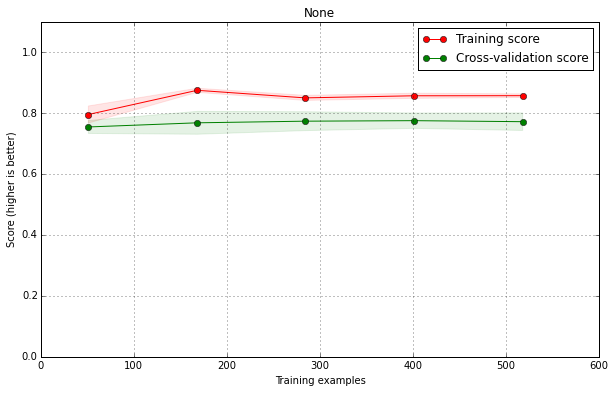

CPU times: user 11.1 s, sys: 8.33 s, total: 19.4 s
Wall time: 29.6 s


In [53]:
%%time

try:
    from sklearn_utilities import plot_learning_curve
except:
    import imp, os
    util = imp.load_source('sklearn_utilities', os.path.expanduser('~/Dropbox/Python/sklearn_utilities.py'))
    from sklearn_utilities import plot_learning_curve

plot_learning_curve(estimator   = clf, 
                    title       = None, 
                    X           = X_train, 
                    y           = y_train, 
                    ylim        = (0.0, 1.10), 
                    cv          = StratifiedKFold(y            = y_train, 
                                                  n_folds      = 10, 
                                                  shuffle      = True, 
                                                  random_state = SEED), 
                    train_sizes = np.linspace(.1, 1.0, 5),
                    n_jobs      = 1)

plt.show()

# Training set predictions

In [54]:
predicted_values = clf.predict(X_train)
y_true, y_pred   = y_train, predicted_values

try:
    predicted_probs  = clf.predict_proba(X_train)
    probs_avail = True
except AttributeError,e:
    probs_avail = False
    print(e)

[[429   9]
 [ 77  61]]


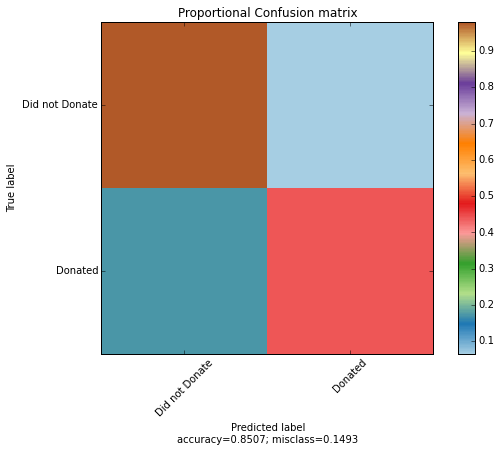

Accuracy 0.8507, mis-class rate 0.1493


In [55]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred, labels=None)
print cm

try:
    from sklearn_utilities import plot_confusion_matrix
except:
    import imp, os
    util = imp.load_source('sklearn_utilities', os.path.expanduser('~/Dropbox/Python/sklearn_utilities.py'))
    from sklearn_utilities import plot_confusion_matrix

plot_confusion_matrix(cm, ['Did not Donate','Donated'])

accuracy = round(np.trace(cm)/float(np.sum(cm)),4)
misclass = 1 - accuracy
print("Accuracy {}, mis-class rate {}".format(accuracy,misclass))

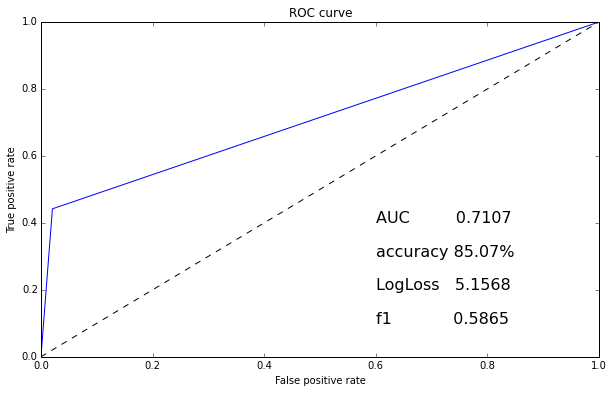

In [56]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score

fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=None)


plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)

plt.text(x=0.6,y=0.4,s="AUC         {:.4f}"\
         .format(roc_auc_score(y_true, y_pred, average='macro')),
        fontsize=16)

plt.text(x=0.6,y=0.3,s="accuracy {:.2f}%"\
         .format(accuracy*100),
        fontsize=16)

plt.text(x=0.6,y=0.2,s="LogLoss   {:.4f}"\
         .format(log_loss(y_true, y_pred)),
        fontsize=16)

plt.text(x=0.6,y=0.1,s="f1            {:.4f}"\
         .format(f1_score(y_true, y_pred)),
        fontsize=16)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

# --------------------------------------------------------------------------------------------

# Test Set Predictions

## Load the test data

In [57]:
from load_blood_data import load_blood_data

X_test, IDs = load_blood_data(train=False, SEED   = SEED, 
                                           scale  = scale,
                                           minmax = minmax,
                                           norm   = norm,
                                           nointercept = nointercept,
                                           engineering = engineering)

# Predict the test set with the fitted model

In [58]:
y_pred        = clf.predict(X_test)
if probs_avail:
    y_pred_probs  = clf.predict_proba(X_test)
    donate_probs  = [prob[1] for prob in y_pred_probs]
else:
    donate_probs = [0.65 if x>0 else 1-0.65 for x in y_pred]

In [59]:
print(y_pred[:10])
if probs_avail: print(y_pred_probs[:10])
print(donate_probs[:10])

[1 0 0 0 1 1 0 0 0 0]
[[ 0.42483333  0.57516667]
 [ 0.83665801  0.16334199]
 [ 0.89266464  0.10733536]
 [ 0.77145238  0.22854762]
 [ 0.41733333  0.58266667]
 [ 0.30433333  0.69566667]
 [ 0.73514267  0.26485733]
 [ 0.9740983   0.0259017 ]
 [ 0.92888784  0.07111216]
 [ 0.97692216  0.02307784]]
[0.5751666666666666, 0.16334199134199132, 0.1073353643019939, 0.22854761904761905, 0.58266666666666667, 0.69566666666666666, 0.26485732688364266, 0.025901700743330331, 0.071112155388471182, 0.023077838827838829]


# Create the submission file

In [60]:
assert len(IDs)==len(donate_probs)

f = open(submission_filename, "w")

f.write(",Made Donation in March 2007\n")
for ID, prob in zip(IDs, donate_probs):
    f.write("{},{}\n".format(ID,prob))
    
f.close()